In [15]:
import pandas as pd
from os import listdir
import numpy as np
from Bio.SeqIO.FastaIO import SimpleFastaParser
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
samples = [
    "cc4_1", "cc4_2", "cc4_3",
    "cd4_1", "cd4_2", "cd4_3",
    "mc4_1", "mc4_2", "mc4_3",
    "md4_1", "md4_2", "md4_3",
    "fc4_1", "fc4_2", "fc4_3",
    "fd4_1", "fd4_2", "fd4_3",
]

hmms = {}

for s in samples:
    base = f"../results_metaspades/{s}/hmms_presence/presence_results.tsv"

    rawdf = pd.read_csv(base, sep="\t")
    
    hmms[s] = rawdf.loc[:, ["name", "match"]].copy()
    

In [3]:
all_hits = []
for _, i in hmms.items():
    all_hits += list(i.name.unique())
    
unique_all_hit = list(set(all_hits))
print(len(unique_all_hit))


m_hits = pd.DataFrame(unique_all_hit, columns=["name"])
m_hits


169


,name
0,vanH
1,APH3
2,tet_MFS_efflux
3,SPM
4,RND_efflux
...,...
164,TetY
165,16S_rRNA_methyltrans
166,ClassA
167,DHA


In [4]:
for s, x in hmms.items():
    x.rename(columns={"match": s}, inplace=True)
    temp = pd.merge(m_hits, x, how="left", on="name")
    m_hits = temp.copy()
    
m_hits

,name,cc4_1,cc4_2,cc4_3,cd4_1,cd4_2,cd4_3,mc4_1,mc4_2,mc4_3,md4_1,md4_2,md4_3,fc4_1,fc4_2,fc4_3,fd4_1,fd4_2,fd4_3
0,vanH,269.0,618.0,724.0,167.0,142.0,144.0,35.0,65.0,144.0,183.0,87.0,284.0,286.0,365.0,429.0,52.0,125.0,61.0
1,APH3,19.0,26.0,28.0,3.0,3.0,1.0,NaN,3.0,5.0,3.0,1.0,4.0,5.0,5.0,8.0,NaN,5.0,2.0
2,tet_MFS_efflux,536.0,1171.0,1433.0,344.0,299.0,291.0,64.0,141.0,316.0,364.0,228.0,712.0,594.0,740.0,892.0,101.0,292.0,145.0
3,SPM,25.0,48.0,45.0,19.0,13.0,16.0,5.0,5.0,8.0,12.0,12.0,25.0,26.0,34.0,34.0,8.0,13.0,13.0
4,RND_efflux,665.0,1412.0,1689.0,541.0,433.0,481.0,154.0,308.0,617.0,808.0,330.0,1093.0,778.0,1013.0,1292.0,161.0,468.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,TetY,89.0,183.0,226.0,63.0,47.0,48.0,10.0,25.0,41.0,66.0,34.0,123.0,98.0,121.0,156.0,13.0,49.0,18.0
165,16S_rRNA_methyltrans,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
166,ClassA,47.0,87.0,113.0,20.0,10.0,15.0,2.0,3.0,10.0,31.0,13.0,30.0,41.0,55.0,67.0,3.0,14.0,8.0
167,DHA,203.0,329.0,406.0,96.0,77.0,95.0,7.0,21.0,63.0,86.0,23.0,115.0,236.0,263.0,319.0,21.0,60.0,39.0


# PCA

In [66]:
def adapt_df_for_PCA(df, pivot):
    raw_newdf = df.T.reset_index()
    newdf = raw_newdf.replace(np.nan, 0, regex=True)

    new_header = newdf.iloc[0] #grab the first row for the header
    newdf = newdf[1:] #take the data less the header row
    newdf.columns = new_header #set the header row as the df header

    sample_id = {
        "cc4": 0,
        "cd4": 1,
        "mc4": 2,
        "md4": 3,
        "fc4": 4,
        "fd4": 5
    }
#     print(newdf)
    newdf["sample"] = newdf.apply(lambda x: x[pivot].split("_")[0] , axis=1)
    newdf["sample_ids"] = newdf.apply(lambda x: sample_id[x["sample"]], axis=1)
    
    macro_sample_id = {
        "c": 0,
        "m": 1,
        "f": 2,
    }
    
    macro_sample_location = {
        "c": "Suna Canottieri",
        "m": "Teatro Maggiore",
        "f": "Fondo Toce",
    }
    newdf["macro_sample"] = newdf.apply(lambda x: x[pivot][0] , axis=1)
    newdf["macro_sample_ids"] = newdf.apply(lambda x: macro_sample_id[x["macro_sample"]], axis=1)
    newdf["macro_sample_location"] = newdf.apply(lambda x: macro_sample_location[x["macro_sample"]], axis=1)
    newdf["coast_deep_shapes"] = newdf.apply(lambda x: "coast" if x["sample"][1] == "c" else "deep", axis=1)
    
    return newdf

In [67]:
newdf = adapt_df_for_PCA(m_hits, pivot="name")
newdf

,name,vanH,APH3,tet_MFS_efflux,SPM,RND_efflux,MarR,Acetyltransf_9,SME,SHV-LEN,...,16S_rRNA_methyltrans,ClassA,DHA,CARB-PSE,sample,sample_ids,macro_sample,macro_sample_ids,macro_sample_location,coast_deep_shapes
1,cc4_1,269.0,19.0,536.0,25.0,665.0,237.0,120.0,18.0,24.0,...,1.0,47.0,203.0,33.0,cc4,0,c,0,Suna Canottieri,coast
2,cc4_2,618.0,26.0,1171.0,48.0,1412.0,482.0,225.0,43.0,47.0,...,0,87.0,329.0,58.0,cc4,0,c,0,Suna Canottieri,coast
3,cc4_3,724.0,28.0,1433.0,45.0,1689.0,584.0,245.0,45.0,48.0,...,2.0,113.0,406.0,67.0,cc4,0,c,0,Suna Canottieri,coast
4,cd4_1,167.0,3.0,344.0,19.0,541.0,122.0,69.0,10.0,9.0,...,0,20.0,96.0,13.0,cd4,1,c,0,Suna Canottieri,deep
5,cd4_2,142.0,3.0,299.0,13.0,433.0,104.0,64.0,6.0,7.0,...,0,10.0,77.0,8.0,cd4,1,c,0,Suna Canottieri,deep
6,cd4_3,144.0,1.0,291.0,16.0,481.0,101.0,68.0,7.0,4.0,...,0,15.0,95.0,8.0,cd4,1,c,0,Suna Canottieri,deep
7,mc4_1,35.0,0,64.0,5.0,154.0,21.0,16.0,0,0,...,0,2.0,7.0,0,mc4,2,m,1,Teatro Maggiore,coast
8,mc4_2,65.0,3.0,141.0,5.0,308.0,55.0,29.0,2.0,2.0,...,0,3.0,21.0,2.0,mc4,2,m,1,Teatro Maggiore,coast
9,mc4_3,144.0,5.0,316.0,8.0,617.0,98.0,60.0,5.0,4.0,...,0,10.0,63.0,6.0,mc4,2,m,1,Teatro Maggiore,coast
10,md4_1,183.0,3.0,364.0,12.0,808.0,110.0,97.0,9.0,7.0,...,0,31.0,86.0,9.0,md4,3,m,1,Teatro Maggiore,deep


In [84]:
newdf.to_csv("hmms_hit_metaspades_table.tsv", sep="\t", index=False, header=True)

In [72]:
def PCA_and_plot(df, features):
    pca = PCA()
    components = pca.fit_transform(df[features])
    
    colors_samples_id = df["sample_ids"]
    colors_samples = df["sample"]
    
    Xt = components
    
    colors_samples_id = df["sample_ids"]
    colors_samples = df["sample"]

    plot = plt.scatter(Xt[:,0], Xt[:,1], c=colors_samples_id, cmap="Paired")
    plt.legend(handles=plot.legend_elements()[0], labels=sorted(set(colors_samples)))
    plt.show()
    
def PCA_and_plot_MACROSAMPLE(df, features):
    pca = PCA()
    components = pca.fit_transform(df[features])
    
    colors_samples_id = df["macro_sample_ids"]
    colors_samples = df["macro_sample"]
    
    Xt = components
    
    colors_samples_id = df["macro_sample_ids"]
    colors_samples = df["macro_sample_location"]
    shapes_samples = list(df["coast_deep_shapes"])

#     plot = plt.scatter(Xt[:,0], Xt[:,1], c=colors_samples_id, cmap="Paired", marker=shapes_samples)
    
    plot = sns.scatterplot(x=Xt[:,0], y=Xt[:,1], hue=colors_samples, palette="tab10", style=shapes_samples)
    
#     plt.legend(handles=plot.legend_elements()[0], labels=sorted(set(colors_samples)))
    plt.show()

In [73]:
features = sorted(m_hits.name)

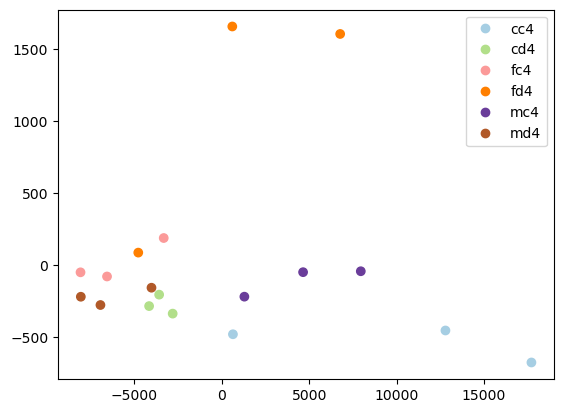

In [74]:
PCA_and_plot(newdf, features)

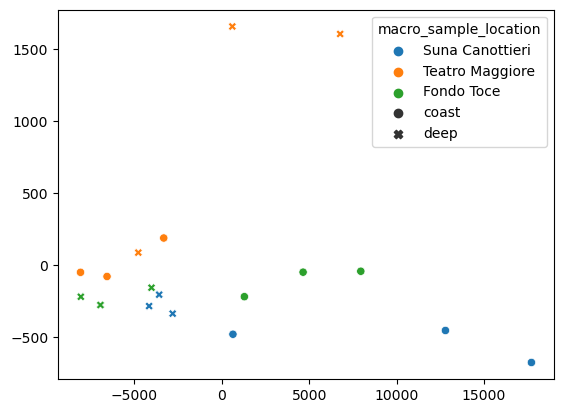

In [75]:
PCA_and_plot_MACROSAMPLE(newdf, features)

# NMDS

In [78]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import seaborn as sns         
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [79]:

X = newdf[features]

# mds = MDS(random_state=0)
# X_transform = mds.fit_transform(X)

dist_manhattan = manhattan_distances(X)
nmds = MDS(dissimilarity='precomputed', random_state=0, metric=False)

# Get the embeddings
X_transform_L1 = nmds.fit_transform(dist_manhattan)

nmds_Xt = X_transform_L1


/home/davide/mambaforge/envs/microbial_res/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [80]:
nmds.stress_

0.2757381174065948

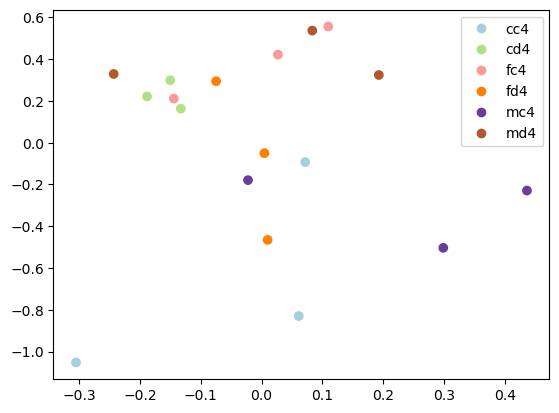

In [81]:
colors_samples_id = newdf["sample_ids"]
colors_samples = newdf["sample"]

plot = plt.scatter(nmds_Xt[:,0], nmds_Xt[:,1], c=colors_samples_id, cmap="Paired")
plt.legend(handles=plot.legend_elements()[0], labels=sorted(set(colors_samples)))
plt.show()

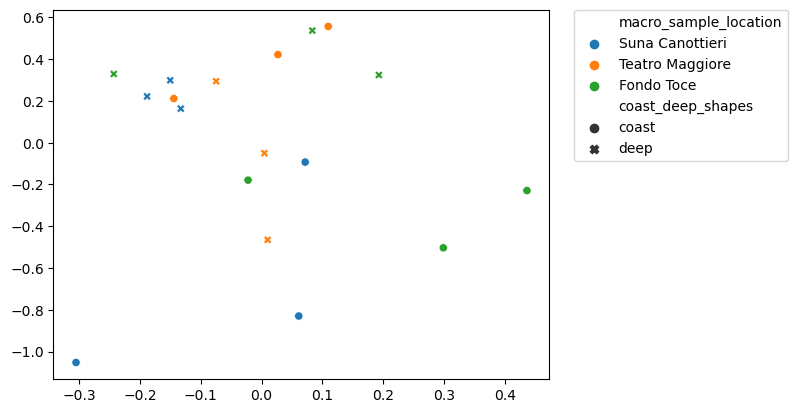

In [83]:
colors_samples_id = newdf["macro_sample_ids"]
colors_samples = newdf["macro_sample_location"]
shapes_samples = newdf["coast_deep_shapes"]

# plot = plt.scatter(nmds_Xt[:,0], nmds_Xt[:,1], c=colors_samples_id, cmap="Paired")
# plt.legend(handles=plot.legend_elements()[0], labels=sorted(set(colors_samples)))

plot = sns.scatterplot(x=nmds_Xt[:,0], y=nmds_Xt[:,1], hue=colors_samples, palette="tab10", style=shapes_samples)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# Random Forest

In [ ]:
import seaborn as sns


In [ ]:
newdf

In [ ]:
y = newdf["macro_sample_ids"]
X = newdf[features]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=3, 
                             max_depth=2,
                             random_state=SEED)

In [ ]:
# Fit RandomForestClassifier
rfc.fit(X_train, y_train)
# Predict the test set labels
y_pred = rfc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix')

print(classification_report(y_test,y_pred))


In [ ]:
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': rfc.feature_names_in_, 'importances': rfc.feature_importances_ })

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted[:10], x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

#### Let's generate a new model with more trees to see how it affects the results. Let's create the rfc_ forest with 900 trees, 8 levels and the same seed. Will the results improve?

In [ ]:
rfc_ = RandomForestClassifier(n_estimators=900, 
                             max_depth=7,
                             random_state=SEED)
rfc_.fit(X_train, y_train)
y_pred = rfc_.predict(X_test)

In [ ]:
cm_ = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_, annot=True, fmt='d').set_title('Confusion matrix for 900 trees with 8 levels')

print(classification_report(y_test,y_pred))